In [141]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import tensorflow as tf
import seaborn as sns
sns.set()

import scipy
from tqdm import tqdm_notebook as tqdm

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [142]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]=""

In [143]:
from model import Model
from options import get_options
from place_cells import PlaceCells
from hd_cells import HDCells

In [144]:
def load_checkpoints(sess, idx):
    saver = tf.train.Saver(max_to_keep=2)
    save_dir = "./saved"
    checkpoint_dir = save_dir + "/checkpoints_seq_100_batch_1000_slow"
    
    checkpoint = tf.train.get_checkpoint_state(checkpoint_dir)
    if checkpoint and checkpoint.model_checkpoint_path:
        saver.restore(sess, checkpoint.all_model_checkpoint_paths[idx])
        
def del_all_flags(FLAGS):
    flags_dict = FLAGS._flags()
    keys_list = [keys for keys in flags_dict]
    for keys in keys_list:
        FLAGS.__delattr__(keys)

In [145]:
tf.reset_default_graph()
del_all_flags(tf.flags.FLAGS) # So we don't run into flag resetting issues
flags = get_options()
model = Model(flags)

sess = tf.Session()
sess.run(tf.local_variables_initializer())
sess.run(tf.global_variables_initializer())
checkpoint = load_checkpoints(sess, -1)

INFO:tensorflow:Restoring parameters from ./saved/checkpoints_seq_100_batch_1000_slow/checkpoint-15999


## Visualize batch

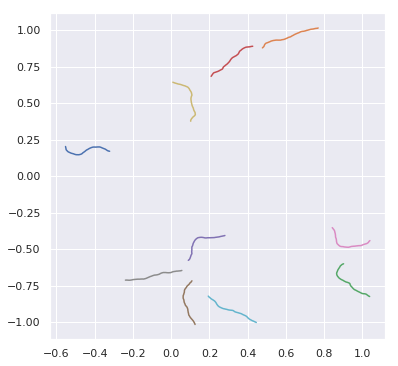

In [146]:
pos_batch = sess.run(model.target_pos)
plt.figure(figsize=(6,6))
for i in range(10):
    plt.plot(pos_batch[i, :, 0], pos_batch[i, :, 1])

## Predicted head direction

In [147]:
hd_cells = HDCells(
    n_cells=flags.num_hd_cells
)

def get_true_hd(hd_outputs):
    true_hd = np.zeros(len(hd_outputs))
    for i in range(len(hd_outputs)):
        true_hd[i] = hd_cells.get_nearest_hd(hd_outputs[i])

    true_hd = true_hd.reshape([flags.batch_size, flags.sequence_length, -1])
    return true_hd

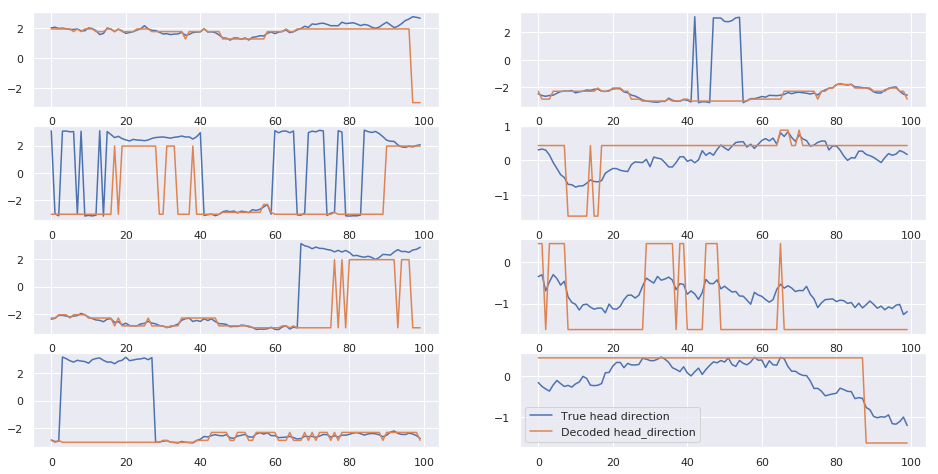

In [148]:
target_hd, hd_outputs_pred = sess.run([model.target_hd, model.hd_outputs_result])

plt.figure(figsize=(16,8))

for i in range(8):
    plt.subplot(4,2,i+1)
    true_hd = get_true_hd(hd_outputs_pred)
    plt.plot(target_hd[i], label='True head direction')
    plt.plot(true_hd[i], label='Decoded head_direction')
#     plt.xlim([-1.5,1.5])
#     plt.ylim([-1.5,1.5])
plt.legend()

## Visualize trajectory

In [149]:
place_cells = PlaceCells(
                n_cells=flags.num_place_cells,
                std=flags.place_cell_rf,
                pos_min=-flags.env_size,
                pos_max=flags.env_size
            )

def get_true_pos(place_outputs):
    true_pos = np.zeros([len(place_outputs), 2])
    for i in range(len(place_outputs)):
        true_pos[i] = place_cells.get_nearest_cell_pos(place_outputs[i])
        
    true_pos = true_pos.reshape([flags.batch_size, flags.sequence_length, -1])
    
    return true_pos

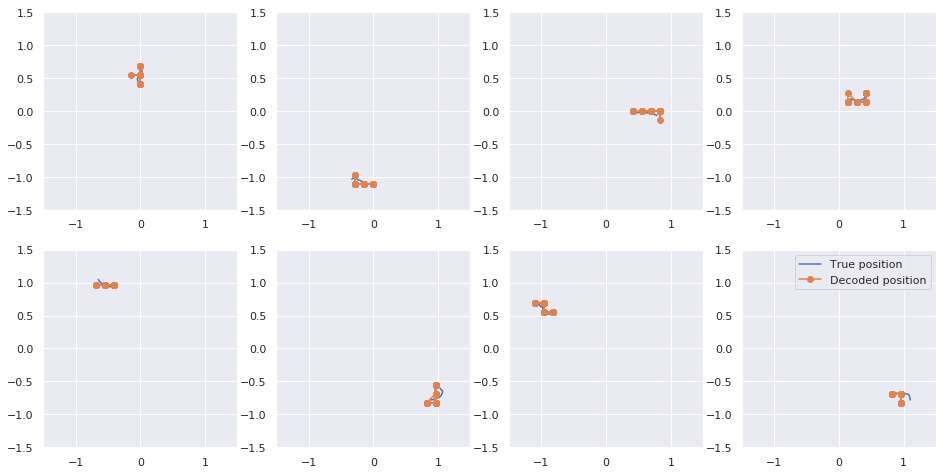

In [150]:
plt.figure(figsize=(16,8))

for i in range(8):
    plt.subplot(2,4,i+1)
    true_pos = get_true_pos(place_outputs_pred)
    plt.plot(target_pos[i,:,0], target_pos[i,:,1], label='True position')
    plt.plot(true_pos[i,:,0], true_pos[i,:,1], 'o-', label='Decoded position')
    plt.xlim([-1.5,1.5])
    plt.ylim([-1.5,1.5])
plt.legend()

# RNN states

In [151]:
index_size= 10
resolution = 50
maze_extents = 1.1

hd_actvs = np.zeros([128, resolution], dtype=np.float32) 
activations = np.zeros([128, resolution, resolution], dtype=np.float32) 
counts  = np.zeros([resolution, resolution], dtype=np.int32)
hd_counts  = np.zeros([resolution], dtype=np.int32)

# Stash activations and positions for later
rnn = np.zeros([index_size, flags.batch_size * flags.sequence_length, 128])
place_pos = np.zeros([index_size, flags.batch_size * flags.sequence_length, 2])
hd = np.zeros([index_size, flags.batch_size * flags.sequence_length])

for index in tqdm(range(index_size)):
    rnn_batch, place_pos_batch, hd_batch = sess.run([model.rnn_output,
                                                     model.target_pos,
                                                     model.target_hd])
    rnn_batch = np.reshape(rnn_batch, [-1, 128])
    place_pos_batch = np.reshape(place_pos_batch, [-1, 2])
    hd_batch = np.reshape(hd_batch, -1)
    
    rnn[index] = rnn_batch
    place_pos[index] = place_pos_batch
    hd[index] = hd_batch
        
    for i in range(flags.batch_size*flags.sequence_length):
        pos_x = place_pos_batch[i,0]
        pos_z = place_pos_batch[i,1]
        x = (pos_x + maze_extents) / (maze_extents * 2) * resolution
        z = (pos_z + maze_extents) / (maze_extents * 2) * resolution
        if x >=0 and x < resolution and z >=0 and z < resolution:
            counts[int(x), int(z)] += 1
            activations[:, int(x), int(z)] += rnn_batch[i, :]
            
        hdx = hd_batch[i]
        hdx = (hdx + np.pi) / (2*np.pi) * resolution
        if hdx >=0 and hdx < resolution:
            hd_counts[int(hdx)] += 1
            hd_actvs[:, int(hdx)] += rnn_batch[i, :]

for x in range(resolution):
    for y in range(resolution):
        if counts[x, y] > 0:
            activations[:, x, y] /= counts[x, y]
            
for hdx in range(resolution):
    if hd_counts[hdx] > 0:
        hd_actvs[:, hdx] /= hd_counts[hdx]
            
rnn = rnn.reshape([-1, 128])
place_pos = place_pos.reshape([-1, 2])
hd = hd.reshape(-1)

HBox(children=(IntProgress(value=0, max=10), HTML(value='')))

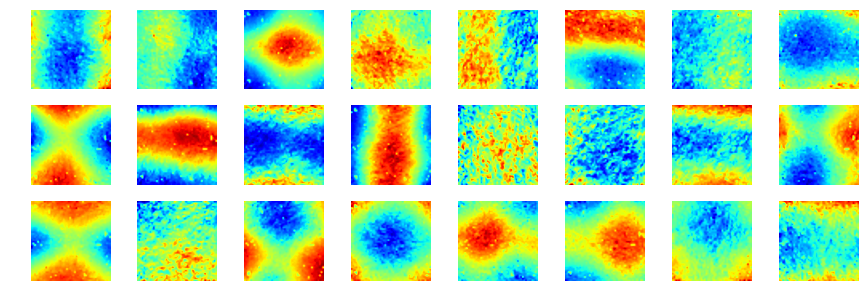

In [152]:
hidden_size = 24

plt.figure(figsize=(15, int(30 * hidden_size / 128)))
for i in range(hidden_size):
    plt.subplot(hidden_size//8, 8, 1 + i)
#     plt.title('Unit ' + str(i))
    plt.imshow(activations[i,:,:], interpolation="gaussian", cmap="jet")
    plt.axis('off')    
plt.show()

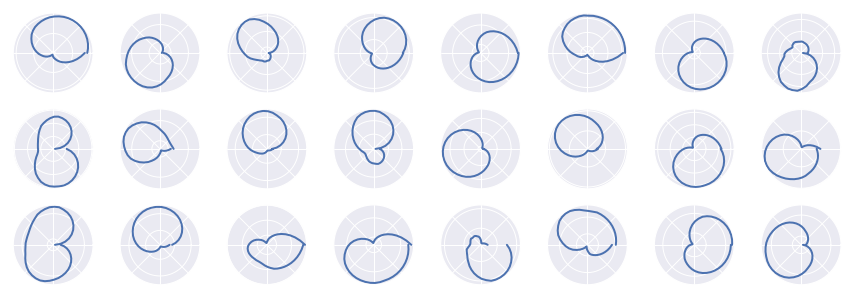

In [153]:
from scipy import signal
hidden_size = 24

plt.figure(figsize=(15, int(30 * hidden_size / 128)))
for i in range(hidden_size):
    ax = plt.subplot(hidden_size//8, 8, 1 + i, projection='polar')
    hd_filt = scipy.signal.savgol_filter(hd_actvs[i], 21, 2)
    ax.plot(np.linspace(0, 2*np.pi, resolution), hd_filt, lw=2)
    ax.set_yticklabels([])
#     ax.set_xticklabels(['0', '', '$\pi/2$', '', '$\pi$', '', '$-\pi/2$']) 
    ax.set_xticklabels([])
plt.show()

### SVD

In [154]:
import scipy
from mpl_toolkits.mplot3d import Axes3D

In [155]:
# Perform SVD
rnn = rnn.reshape([-1, 128])
idxs = np.random.randint(0, len(rnn), 5000)
X = rnn[idxs].T

U, S, V = scipy.linalg.svd(X)

rnn_embed = U.T.dot(X)

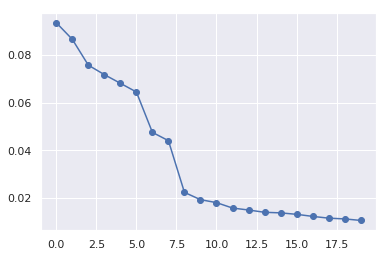

In [156]:
plt.plot(S[:20]/np.sum(S), 'o-')

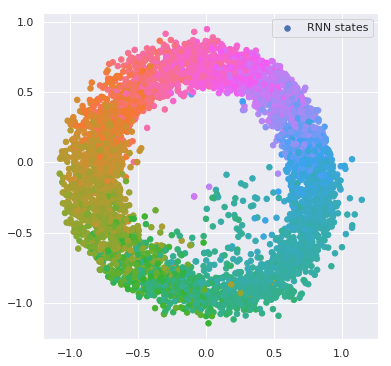

In [157]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)

cmap = mpl.colors.ListedColormap(sns.husl_palette(256))
ax.scatter(rnn_embed[0, :], rnn_embed[1, :], c=hd[idxs], s=30, cmap=cmap, label='RNN states')

plt.legend()

## Grid cells

In [167]:
index_size= 10
resolution = 50
maze_extents = 1.1

hd_actvs = np.zeros([512, resolution], dtype=np.float32) 
activations = np.zeros([512, resolution, resolution], dtype=np.float32) 
counts  = np.zeros([resolution, resolution], dtype=np.int32)
hd_counts  = np.zeros([resolution], dtype=np.int32)

# Stash activations and positions for later
g = np.zeros([index_size, flags.batch_size * flags.sequence_length, 512])
place_pos = np.zeros([index_size, flags.batch_size * flags.sequence_length, 2])
hd = np.zeros([index_size, flags.batch_size * flags.sequence_length])

for index in tqdm(range(index_size)):
    g_batch, place_pos_batch, hd_batch = sess.run([model.g,
                                                     model.target_pos,
                                                     model.target_hd])
    place_pos_batch = np.reshape(place_pos_batch, [-1, 2])
    hd_batch = np.reshape(hd_batch, -1)
    
    g[index] = g_batch
    place_pos[index] = place_pos_batch
    hd[index] = hd_batch
        
    for i in range(flags.batch_size*flags.sequence_length):
        pos_x = place_pos_batch[i,0]
        pos_z = place_pos_batch[i,1]
        x = (pos_x + maze_extents) / (maze_extents * 2) * resolution
        z = (pos_z + maze_extents) / (maze_extents * 2) * resolution
        if x >=0 and x < resolution and z >=0 and z < resolution:
            counts[int(x), int(z)] += 1
            activations[:, int(x), int(z)] += g_batch[i, :]
            
        hdx = hd_batch[i]
        hdx = (hdx + np.pi) / (2*np.pi) * resolution
        if hdx >=0 and hdx < resolution:
            hd_counts[int(hdx)] += 1
            hd_actvs[:, int(hdx)] += g_batch[i, :]

for x in range(resolution):
    for y in range(resolution):
        if counts[x, y] > 0:
            activations[:, x, y] /= counts[x, y]
            
for hdx in range(resolution):
    if hd_counts[hdx] > 0:
        hd_actvs[:, hdx] /= hd_counts[hdx]
            
g = g.reshape([-1, 512])
place_pos = place_pos.reshape([-1, 2])
hd = hd.reshape(-1)
rate_map = np.reshape(activations, [512, -1])

HBox(children=(IntProgress(value=0, max=10), HTML(value='')))

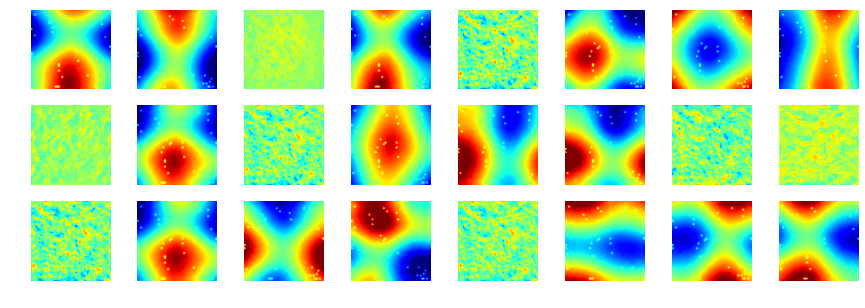

In [170]:
hidden_size = 24

plt.figure(figsize=(15, int(30 * hidden_size / 128)))
for i in range(hidden_size):
    plt.subplot(hidden_size//8, 8, 1 + i)
#     plt.title('Unit ' + str(i))
    plt.imshow(activations[i,:,:], interpolation="gaussian", cmap="jet", vmin=-1.5, vmax=1.5)
    plt.axis('off')    
plt.show()

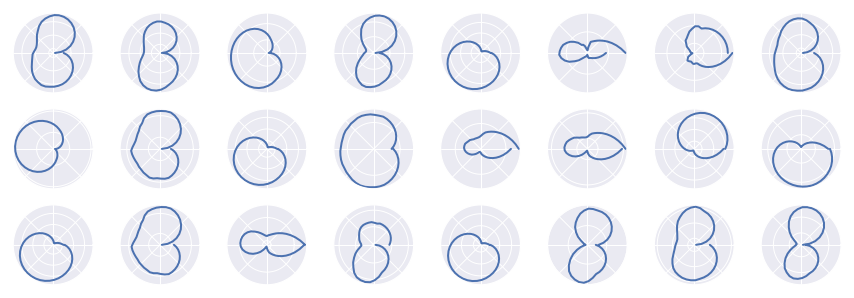

In [169]:
from scipy import signal
hidden_size = 24

plt.figure(figsize=(15, int(30 * hidden_size / 128)))
for i in range(hidden_size):
    ax = plt.subplot(hidden_size//8, 8, 1 + i, projection='polar')
    hd_filt = scipy.signal.savgol_filter(hd_actvs[i], 21, 2)
    ax.plot(np.linspace(0, 2*np.pi, resolution), hd_filt, lw=2)
    ax.set_yticklabels([])
#     ax.set_xticklabels(['0', '', '$\pi/2$', '', '$\pi$', '', '$-\pi/2$']) 
    ax.set_xticklabels([])
plt.show()

## SVD

In [171]:
import scipy
from mpl_toolkits.mplot3d import Axes3D

In [172]:
# Perform SVD
U, S, V = scipy.linalg.svd(rate_map)

rm_embed = U.T.dot(rate_map)

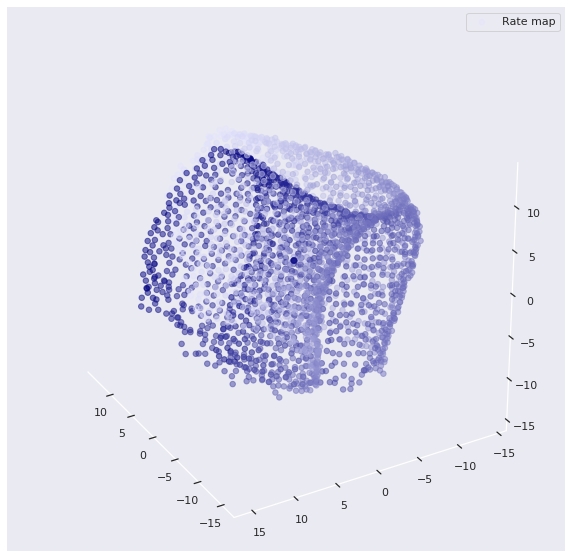

In [177]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
# h = ax.scatter(Xtilde[0, :], Xtilde[1, :], Xtilde[2, :],
#                c=place_pos[:,1], label='Neural states')


cmap = sns.light_palette("navy", as_cmap=True)
x = np.repeat(np.arange(resolution), resolution)
y = np.tile(np.arange(resolution), resolution)
ax.scatter(rm_embed[0, :], rm_embed[1, :], rm_embed[2, :], c=y, s=30, label='Rate map', cmap=cmap, alpha=0.5)

# make the panes transparent
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# make the grid lines transparent
ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)


ax.view_init(30, 150)
plt.legend()

### Movie

In [181]:
import matplotlib.animation as animation
from IPython.display import HTML
from mpl_toolkits.mplot3d.art3d import juggle_axes

In [183]:
g, place_pos= sess.run([model.g, model.target_pos])
place_pos = np.reshape(place_pos, [-1, 2])

idxs = np.arange(1000)
traj_embed = U.T.dot(g[idxs].T)

<IPython.core.display.Javascript object>


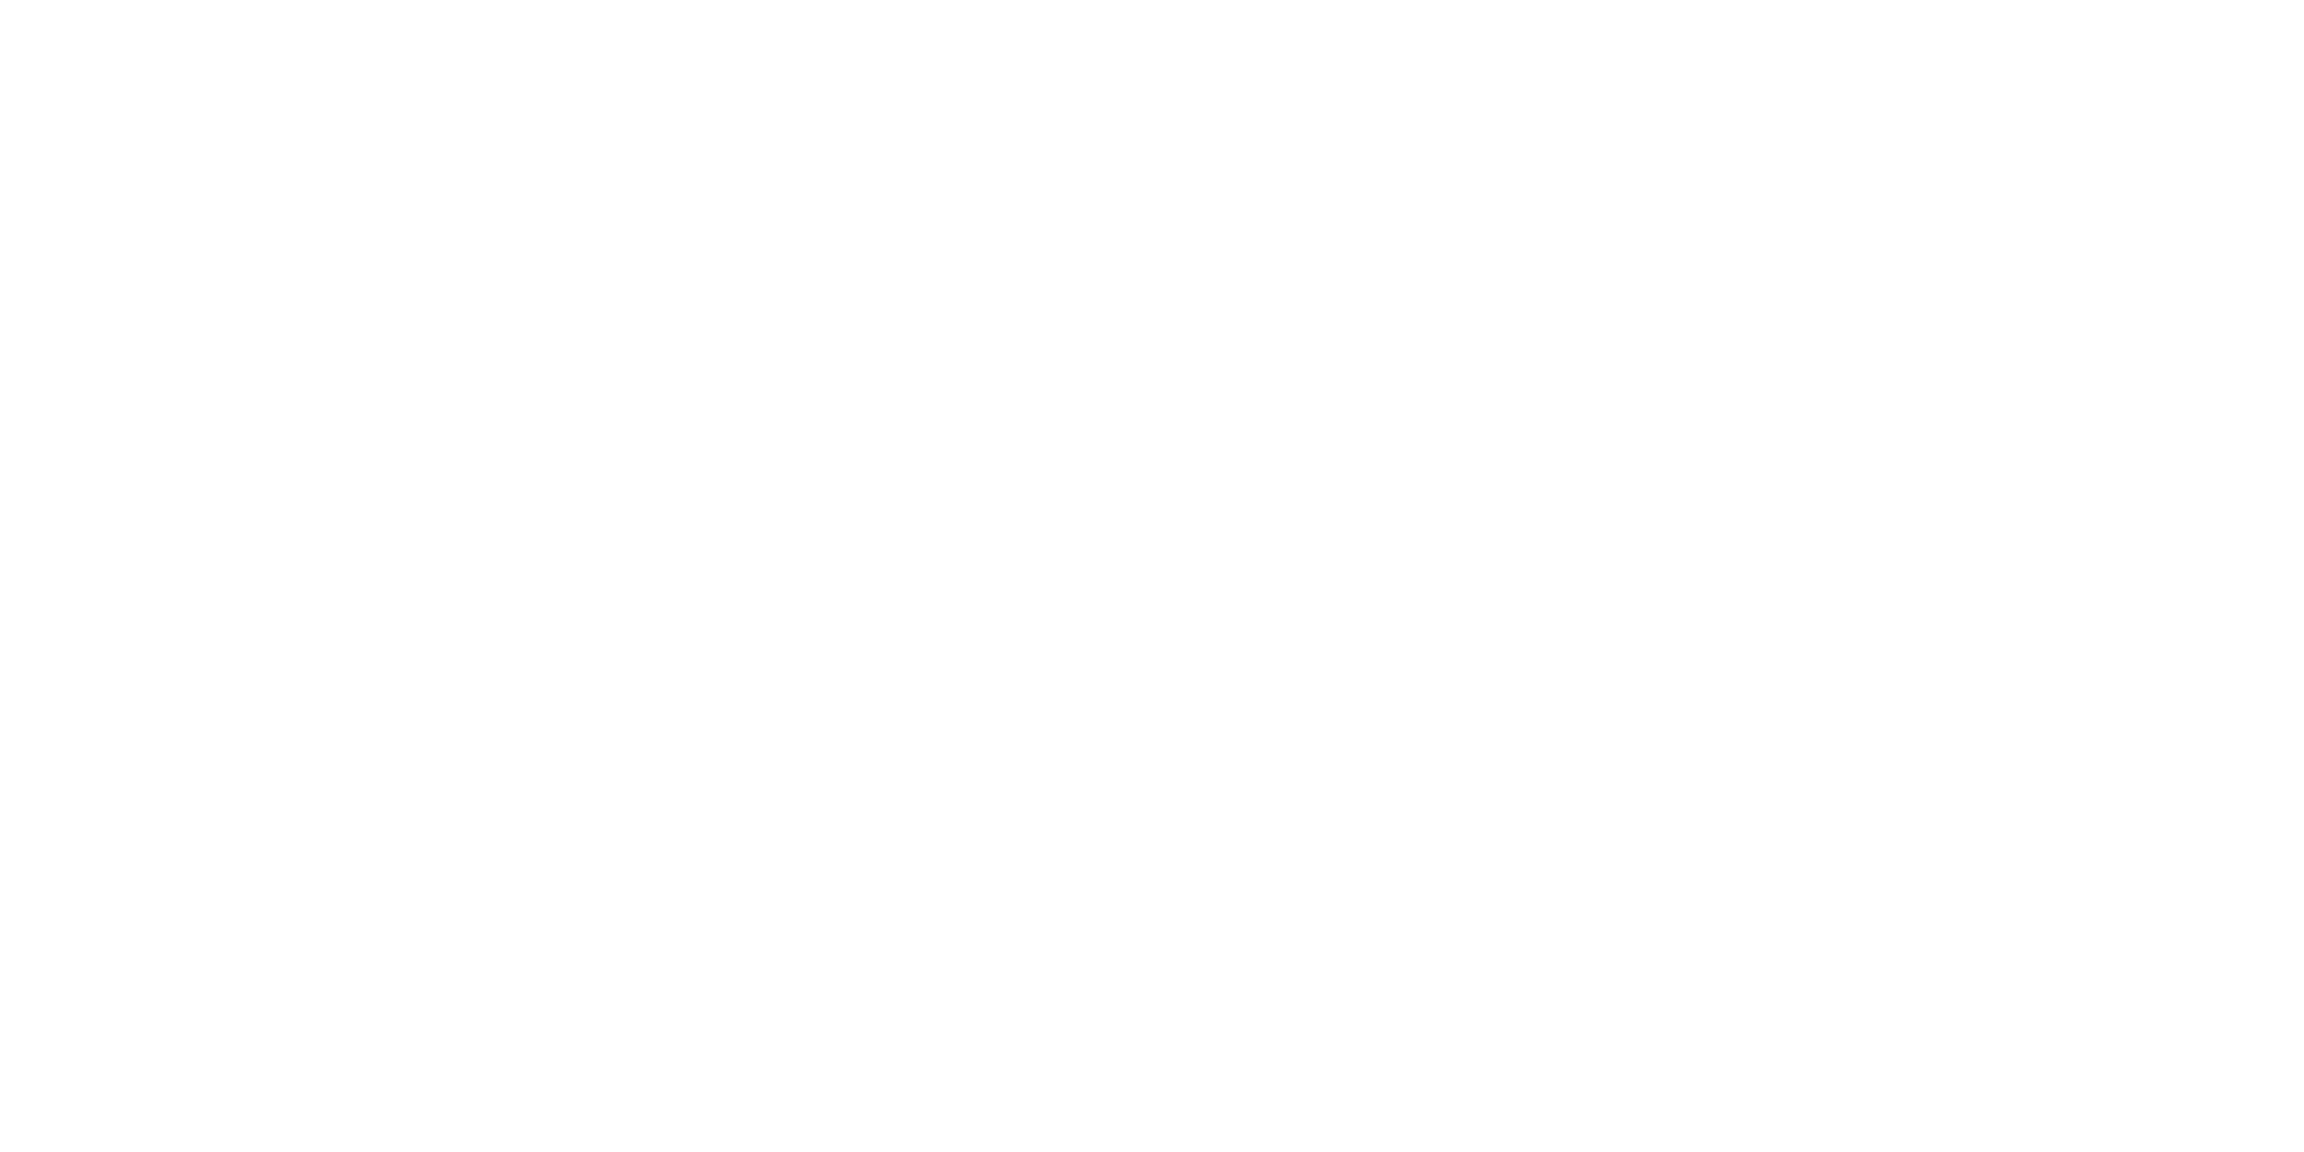

<IPython.core.display.Javascript object>


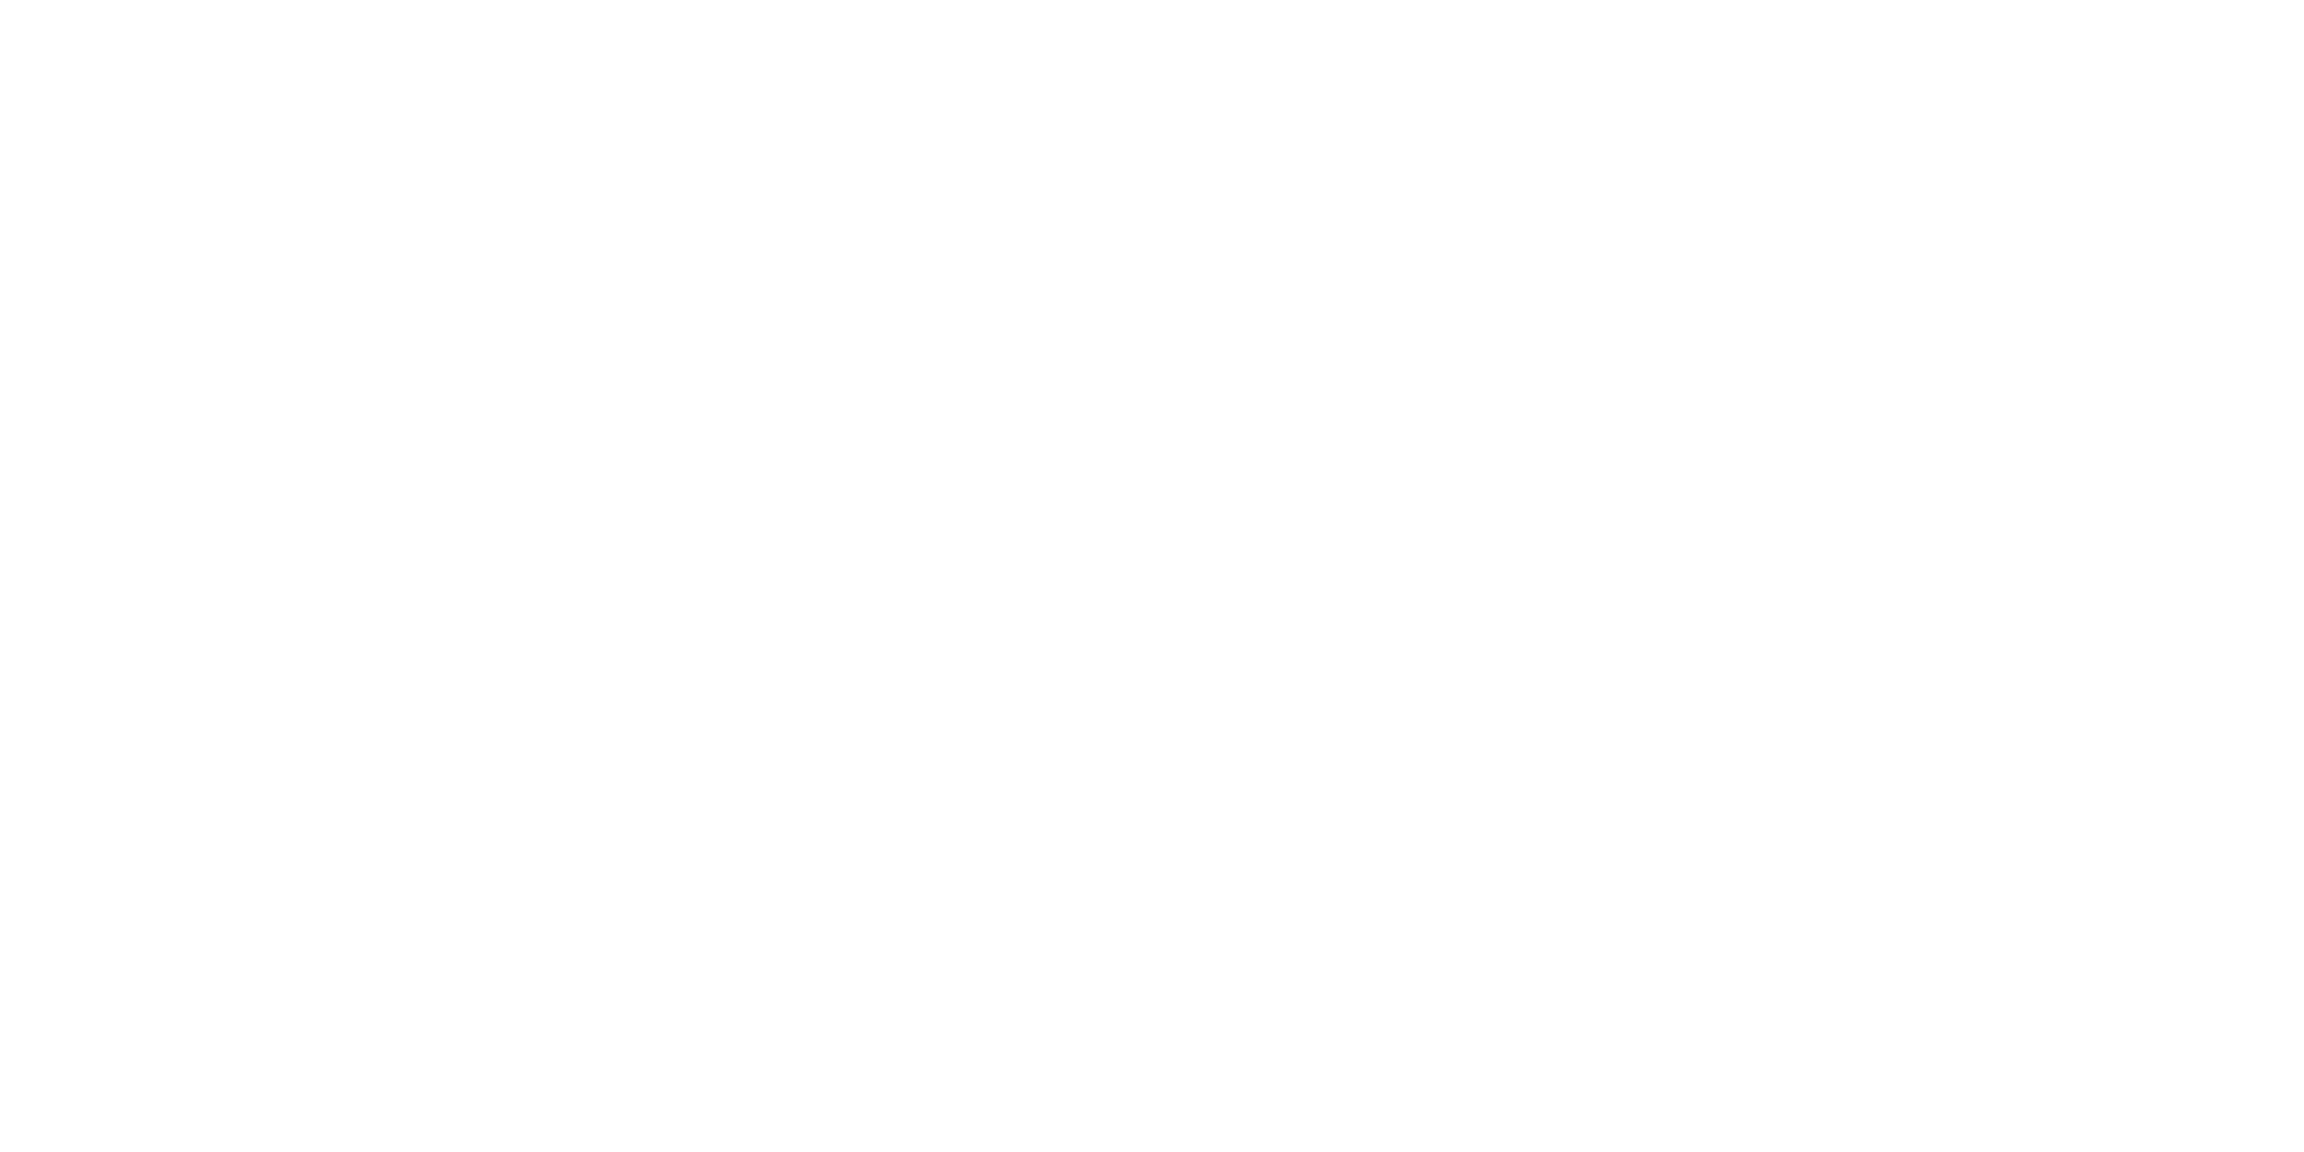

Traceback (most recent call last):
  File "/Users/bensorscher/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py", line 215, in process
    func(*args, **kwargs)
  File "/Users/bensorscher/anaconda3/lib/python3.6/site-packages/matplotlib/animation.py", line 1478, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


In [185]:
# Movie of trajectory on manifold
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122)

x = np.ones(1000)*100
y = np.ones(1000)*100
z = np.ones(1000)*100

xc = np.repeat(np.arange(resolution), resolution)
yc = np.tile(np.arange(resolution), resolution)
ax.scatter(rm_embed[0, :], rm_embed[1, :], rm_embed[2, :], c=yc, s=10, label='Rate map')
scat = ax.scatter(x, y, z, s=30)

x2 = np.ones(1000)*100
y2 = np.ones(1000)*100
scat2 = ax2.scatter(x2, y2, s=10)

def update_plot(i, x, y, z, scat):
    i *= 10
    
    start_idx = np.maximum(i-100, 0)
    x = np.ones(1000)*100
    y = np.ones(1000)*100
    z = np.ones(1000)*100
    x[start_idx:i] = traj_embed[0, start_idx:i]
    y[start_idx:i] = traj_embed[1, start_idx:i]
    z[start_idx:i] = traj_embed[2, start_idx:i]
    scat._offsets3d = juggle_axes(x, y, z, 'z')
    
    x2 = np.ones(1000)*100
    y2 = np.ones(1000)*100
    x2[start_idx:i] = place_pos[start_idx:i,0]
    y2[start_idx:i] = place_pos[start_idx:i,1]
    scat2.set_offsets(np.concatenate([x2[:,None],y2[:,None]], axis=1))
    
    ax.azim -=0.5
    
    return scat, scat2,

ax.set_xlim3d([-10,10])
ax.set_ylim3d([-10,10])
ax.set_zlim3d([-10,10])
ax.view_init(30, 150)
ax.set_title('Neural state')

ax2.set_xlim([-20, 20])
ax2.set_ylim([-20, 20])
ax2.vlines([-1.1, 1.1], -1.1, 1.1, colors='C1')
ax2.hlines([-1.1, 1.1], -1.1, 1.1, colors='C1')
ax2.set_title('True position')

# Plot movie
ani = animation.FuncAnimation(fig, update_plot, frames=100,
                              fargs=(x, y, z, scat),
                              interval=100, blit=True)
HTML(ani.to_html5_video())

## SVD decoder weights

In [186]:
W1, W2, M = sess.run([tf.trainable_variables('model/outputs/dense/kernel'), 
                     tf.trainable_variables('model/outputs/dense_1/kernel'), 
                     tf.trainable_variables('model/dense_4/kernel')])
W1 = W1[0]
W2 = W2[0]
M = M[0]

W = np.concatenate([W1, W2], axis=1)
D = M.dot(W)

In [187]:
sns.set_style('white')
sns.set_style({'axes.edgecolor': '.4'})

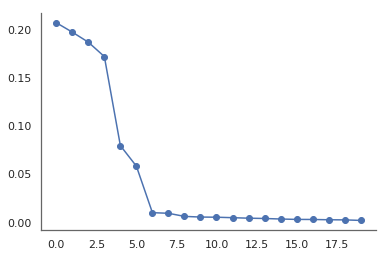

In [189]:
%matplotlib inline
Ud, Sd, Vd = scipy.linalg.svd(D - np.mean(D, axis=0))

plt.plot(Sd[:20]/np.sum(Sd), 'o-', c='C0')
sns.despine()

## Persistence homology

In [195]:
from ripser import ripser, plot_dgms
from scipy.spatial.distance import pdist, squareform

In [ ]:
res = ripser(rm_embed[:4].T, maxdim=2)  # use only the first 10 dimensions
diagrams = res['dgms']
plot_dgms(diagrams, show=True)

<BarContainer object of 968 artists>

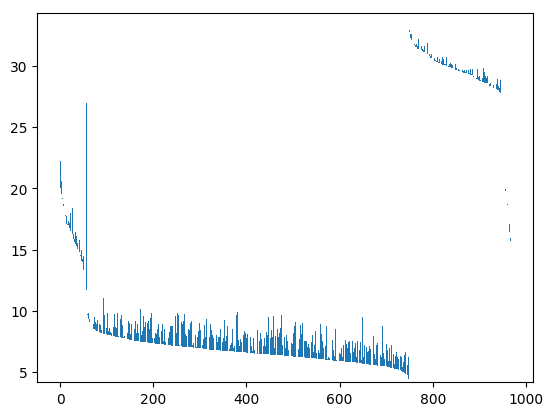

In [188]:
bottoms = np.concatenate([diagrams[1][:,0], diagrams[2][:,0]])
tops = np.concatenate([diagrams[1][:,1], diagrams[2][:,1]])
heights = tops - bottoms

plt.bar(np.arange(len(heights)), heights, bottom=bottoms)